# Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond

In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to kill creature in VizDoom. 

To learn more, read here: https://medium.com/p/8438a3e2b8df

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents

In [73]:
from __future__ import division


import gym

import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
from helper import make_gif
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

Feel free to change the Vizdoom map!

In [74]:
from vizdoom import *
a_size = 3 # Agent can move Left, Right, or Fire

#The Below code is related to setting up the Doom environment
game = DoomGame()
game.set_doom_scenario_path("defend_the_center.wad")  #This corresponds to the simple task we will pose our agent
game.load_config("../../scenarios/rocket_basic.cfg")
game.set_doom_map("map01")
game.set_screen_resolution(ScreenResolution.RES_160X120)
game.set_screen_format(ScreenFormat.GRAY8)
game.set_render_hud(False)
game.set_render_crosshair(False)
game.set_render_weapon(True)
game.set_render_decals(False)
game.set_render_particles(False)

game.add_available_button(Button.TURN_LEFT)
game.add_available_button(Button.TURN_RIGHT)
game.add_available_button(Button.ATTACK)
actions_list = np.identity(a_size,dtype=bool).tolist()
print(actions_list)

game.add_available_game_variable(GameVariable.AMMO2)
game.add_available_game_variable(GameVariable.POSITION_X)
game.add_available_game_variable(GameVariable.POSITION_Y)
game.set_episode_timeout(300)
game.set_episode_start_time(10)
game.set_window_visible(False)
game.set_sound_enabled(False)
#game.set_living_reward(-1)
game.set_mode(Mode.PLAYER)
game.init()

#End Doom set-up

env = game


[[True, False, False], [False, True, False], [False, False, True]]


Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network itself

In [75]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,7056],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,1])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,a_size]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay

This class allows us to store experies and sample then randomly to train the network.

In [76]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

This is a simple function to resize our game frames.

In [77]:
def processState(states):
    return np.reshape(states,[21168])

# Processes Doom screen image to produce cropped and resized image. 
def process_frame(frame):
    s = frame[10:-10,30:-30]
    s = scipy.misc.imresize(s,[84,84])
    s = np.reshape(s,[np.prod(s.shape)]) / 255.0
    return s
    

These functions allow us to update the parameters of our target network with those of the primary network.

In [78]:
def updateTargetGraph(tfVars,tau):
    #tfVars are all the trainable values of the computation graph, e.i. all the weights of the networks (main and target)
    #tau is the the ratio to which we update the Target network with respect to the Main network
    total_vars = len(tfVars)
    op_holder = []
    #Here we need to understand the structure of the tfVars array.
    #The first half entries are the trainable values of the Main Network
    #The last half entries are the trainable values of the Main Network
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        #New_targetNet_values = tau * New_MainNet_values + (1 - tau) * Old_MainNet_values
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

#This function just runs the session to compute the above expression
def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Training the network

Setting all the training parameters

In [83]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 300 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network
saveframes = True


In [84]:

if saveframes == True:
    if not os.path.exists('./DDDQN_VizDoom_frames'):
        os.makedirs('./DDDQN_VizDoom_frames')
        
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

#trainable variables of the Main Network and the Target Network
trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episodes
jList = []
rList = []
total_steps = 0


#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        #GAther episode frames to create gifs eventuly
        episode_frames = []
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        env.new_episode()
        s = env.get_state().screen_buffer
        s = process_frame(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,a_size)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0] #Feed through main network to predict action
            
            r = env.make_action(actions_list[a])
            d = env.is_episode_finished()
            if d == False:
                s1 = env.get_state().screen_buffer
            else:
                break
            episode_frames.append(s1)
            s1 = process_frame(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop #epsilon annealing
                
                if total_steps % (update_freq) == 0:
                    #Get a random batch of experiences from the episode buffer
                    trainBatch = myBuffer.sample(batch_size)
                    
                    #Below we perform the Double-DQN update to the target Q-values
                    
                    #First we calculate the best actions for state s1 in each experience of the batch using our Main Network
                    A = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    #Then we calculate the Qvalues for every selected experiences in the batch using our Target Network.
                    #So Q2 is a 2D-array containing a vector of Q-values for each randomly selected experiences in the batch
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    #the end multiplier goes to zero if the experience is an "end of game", so the target Q-value = the reward
                    end_multiplier = -(trainBatch[:,4] - 1) 
                    
                    #doubleQs are the Q-values estimated from Q2 at state s1 given action A = argmax(Q1(s1,:)). 
                    #So doubleQ is a vector containing the estimated Q-values for the best action possible 
                    #for each randomly selected experience in the batch.
                    doubleQ = Q2[range(batch_size),A]
                    
                    # Target-Q = r + gamma*(doubleQ) for non "end-of-game" experiences. Otherwise Target-Q = Reward
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    
                    #Update the Main network with our target Q-values.
                    _ = sess.run(mainQN.updateModel, \
                                   #loss function to optimize                    
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    #Update the Target network toward the main network but slowly (with a tau rate)
                    updateTarget(targetOps,sess)
                    
            rAll += r
            s = s1

        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 500 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
            time_per_step = 0.05
            gif_cnt_down = 10
            
        if saveframes == True and 0 < gif_cnt_down < 11:
            images = np.array(episode_frames)
            make_gif(images,'./DDDQN_VizDoom_frames/image'+str(i)+'.gif', 
                     duration=len(images)*time_per_step,true_image=True,salience=False)
            gif_cnt_down -= 1
            
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model


 93%|███████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:00<00:00, 382.11it/s]


1576 -136.0 1
2537 -39.3 1
3713 -66.3 1
5655 -204.8 1
6723 -54.0 1
8323 -151.0 1
9165 -12.3 1
10631 -124.0 0.9432099999999782
12201 -135.9 0.8019099999999241
14040 -190.5 0.6363999999998606
16286 -247.8 0.43425999999982373
18438 -224.3 0.24057999999986604
19962 -114.7 0.10341999999985577
22022 -197.5 0.09999999999985551
22544 33.8 0.09999999999985551
23506 -46.4 0.09999999999985551
24140 9.5 0.09999999999985551
25125 -52.3 0.09999999999985551
25860 1.9 0.09999999999985551
26962 -54.4 0.09999999999985551
27413 35.3 0.09999999999985551
28090 4.7 0.09999999999985551
29127 -60.0 0.09999999999985551
29315 79.2 0.09999999999985551
30173 -24.0 0.09999999999985551
31142 -37.1 0.09999999999985551
32133 -37.3 0.09999999999985551
32772 14.5 0.09999999999985551
33746 -45.2 0.09999999999985551
34879 -65.1 0.09999999999985551
35855 -21.2 0.09999999999985551
36896 -35.2 0.09999999999985551
37742 -11.8 0.09999999999985551
38544 -15.4 0.09999999999985551
38899 59.0 0.09999999999985551
39369 37.9 0.0999

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [00:00<00:00, 290.14it/s]


49518 12.4 0.09999999999985551
49949 42.8 0.09999999999985551
50357 43.1 0.09999999999985551
50896 29.0 0.09999999999985551
51809 -27.0 0.09999999999985551
52538 -7.6 0.09999999999985551
53555 -49.5 0.09999999999985551
54392 -8.8 0.09999999999985551
55167 2.4 0.09999999999985551
56202 -58.3 0.09999999999985551
57458 -89.5 0.09999999999985551
58158 -4.2 0.09999999999985551
58638 33.9 0.09999999999985551
59146 31.1 0.09999999999985551
59253 89.8 0.09999999999985551
60043 -14.7 0.09999999999985551
60984 -32.8 0.09999999999985551
61306 65.8 0.09999999999985551
61810 42.1 0.09999999999985551
62261 35.8 0.09999999999985551
63392 -70.9 0.09999999999985551
63555 83.7 0.09999999999985551
64261 -6.8 0.09999999999985551
65199 -26.5 0.09999999999985551
65309 89.5 0.09999999999985551
66048 -11.1 0.09999999999985551
66959 -26.8 0.09999999999985551
67381 44.7 0.09999999999985551
67832 37.3 0.09999999999985551
68816 -32.6 0.09999999999985551
68949 86.7 0.09999999999985551
69039 92.0 0.0999999999998555

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [00:00<00:00, 299.80it/s]


82728 56.1 0.09999999999985551
84050 -79.4 0.09999999999985551
84750 7.4 0.09999999999985551
85158 45.1 0.09999999999985551
85336 82.2 0.09999999999985551
86026 4.3 0.09999999999985551
86185 84.6 0.09999999999985551
86348 82.7 0.09999999999985551
86466 88.7 0.09999999999985551
87040 25.0 0.09999999999985551
87195 84.5 0.09999999999985551
87577 59.3 0.09999999999985551
88790 -69.1 0.09999999999985551
89655 -12.2 0.09999999999985551
90275 22.4 0.09999999999985551
90416 86.4 0.09999999999985551
91102 7.2 0.09999999999985551
91393 66.4 0.09999999999985551
91661 73.2 0.09999999999985551
92095 52.6 0.09999999999985551
92713 18.1 0.09999999999985551
93517 1.0 0.09999999999985551
94297 -5.2 0.09999999999985551
95148 -18.8 0.09999999999985551
95526 59.7 0.09999999999985551
95753 76.3 0.09999999999985551
95988 76.0 0.09999999999985551
96446 38.6 0.09999999999985551
96947 36.8 0.09999999999985551
97349 42.2 0.09999999999985551
97908 30.0 0.09999999999985551
98025 88.8 0.09999999999985551
98124 91

 98%|███████████████████████████████████████████████████████████████████████████████▊ | 65/66 [00:00<00:00, 276.41it/s]


106587 32.8 0.09999999999985551
107189 26.2 0.09999999999985551
107421 74.8 0.09999999999985551
107783 58.8 0.09999999999985551
108020 76.3 0.09999999999985551
108242 77.3 0.09999999999985551
108584 62.3 0.09999999999985551
109039 37.9 0.09999999999985551
109160 88.9 0.09999999999985551
109292 87.3 0.09999999999985551
109443 84.9 0.09999999999985551
110252 -1.0 0.09999999999985551
110359 89.8 0.09999999999985551
110678 64.6 0.09999999999985551
111046 61.2 0.09999999999985551
111332 71.9 0.09999999999985551
112098 -2.8 0.09999999999985551
112262 83.6 0.09999999999985551
112491 77.6 0.09999999999985551
112658 83.3 0.09999999999985551
112800 86.8 0.09999999999985551
113120 66.0 0.09999999999985551
113532 41.7 0.09999999999985551
113849 66.8 0.09999999999985551
114092 74.7 0.09999999999985551
114293 79.9 0.09999999999985551
114481 81.2 0.09999999999985551
114843 60.8 0.09999999999985551
114985 86.8 0.09999999999985551
115226 74.4 0.09999999999985551
115339 89.7 0.09999999999985551
116081 -

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [00:00<00:00, 310.14it/s]


121362 66.3 0.09999999999985551
121535 82.7 0.09999999999985551
122030 32.9 0.09999999999985551
122157 87.8 0.09999999999985551
122283 87.9 0.09999999999985551
122458 82.0 0.09999999999985551
122892 40.5 0.09999999999985551
123087 79.5 0.09999999999985551
123180 91.7 0.09999999999985551
123345 84.0 0.09999999999985551
123570 78.0 0.09999999999985551
123694 88.6 0.09999999999985551
123871 83.3 0.09999999999985551
124337 38.8 0.09999999999985551
124515 82.2 0.09999999999985551
124651 86.9 0.09999999999985551
124792 85.9 0.09999999999985551
125187 42.4 0.09999999999985551
125540 63.2 0.09999999999985551
125778 76.2 0.09999999999985551
126068 69.0 0.09999999999985551
126424 61.4 0.09999999999985551
126591 83.3 0.09999999999985551
127141 26.9 0.09999999999985551
127734 26.1 0.09999999999985551
127858 88.6 0.09999999999985551
128150 70.3 0.09999999999985551
128295 86.0 0.09999999999985551
128709 55.1 0.09999999999985551
128991 70.3 0.09999999999985551
129143 84.8 0.09999999999985551
129334 8

 92%|██████████████████████████████████████████████████████████████████████████▎      | 11/12 [00:00<00:00, 323.32it/s]


134812 90.9 0.09999999999985551
134957 86.0 0.09999999999985551
135334 60.8 0.09999999999985551
135551 77.3 0.09999999999985551
135765 77.6 0.09999999999985551
135982 77.8 0.09999999999985551
136409 53.8 0.09999999999985551
136570 83.9 0.09999999999985551
136740 83.0 0.09999999999985551
137056 65.4 0.09999999999985551
137247 80.9 0.09999999999985551
137846 25.5 0.09999999999985551
137988 86.3 0.09999999999985551
138094 90.4 0.09999999999985551
138486 58.3 0.09999999999985551
138822 64.9 0.09999999999985551
139141 65.6 0.09999999999985551
139262 88.9 0.09999999999985551
139580 67.2 0.09999999999985551
139759 83.1 0.09999999999985551
140261 33.2 0.09999999999985551
140593 64.8 0.09999999999985551
140911 65.7 0.09999999999985551
141411 48.0 0.09999999999985551
141849 42.1 0.09999999999985551
141997 86.2 0.09999999999985551
142088 91.9 0.09999999999985551
142227 86.6 0.09999999999985551
142403 80.9 0.09999999999985551
142803 57.5 0.09999999999985551
142916 89.7 0.09999999999985551
143205 6

 97%|██████████████████████████████████████████████████████████████████████████████▊  | 37/38 [00:00<00:00, 303.07it/s]


147979 82.8 0.09999999999985551
148686 0.6 0.09999999999985551
148864 81.7 0.09999999999985551
149229 61.5 0.09999999999985551
149564 65.5 0.09999999999985551
149667 90.7 0.09999999999985551
149947 70.0 0.09999999999985551
150219 71.3 0.09999999999985551
150418 80.1 0.09999999999985551
150577 84.6 0.09999999999985551
150904 64.8 0.09999999999985551
151192 70.7 0.09999999999985551
151399 79.8 0.09999999999985551
151841 42.7 0.09999999999985551
152329 39.6 0.09999999999985551
152494 84.5 0.09999999999985551
152696 80.3 0.09999999999985551
152917 75.4 0.09999999999985551
153056 86.6 0.09999999999985551
153250 80.1 0.09999999999985551
153424 83.1 0.09999999999985551
153617 81.2 0.09999999999985551
153787 83.0 0.09999999999985551
154061 72.1 0.09999999999985551
154396 63.0 0.09999999999985551
154560 83.6 0.09999999999985551
154739 82.1 0.09999999999985551
155055 65.9 0.09999999999985551
155245 82.0 0.09999999999985551
155383 87.2 0.09999999999985551
156079 10.8 0.09999999999985551
156431 63

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 32/33 [00:00<00:00, 293.38it/s]


160322 79.5 0.09999999999985551
160471 85.6 0.09999999999985551
160624 84.7 0.09999999999985551
160827 78.7 0.09999999999985551
161359 43.3 0.09999999999985551
161518 84.6 0.09999999999985551
161681 84.7 0.09999999999985551
162235 31.5 0.09999999999985551
162582 63.8 0.09999999999985551
162759 82.3 0.09999999999985551
162922 83.2 0.09999999999985551
163061 87.1 0.09999999999985551
163518 40.7 0.09999999999985551
163643 88.5 0.09999999999985551
163822 82.6 0.09999999999985551
164018 80.9 0.09999999999985551
164169 85.4 0.09999999999985551
164319 85.0 0.09999999999985551
164503 81.6 0.09999999999985551
164611 90.2 0.09999999999985551
165070 42.0 0.09999999999985551
165206 87.4 0.09999999999985551
165476 72.0 0.09999999999985551
165756 71.5 0.09999999999985551
166069 65.7 0.09999999999985551
166421 63.3 0.09999999999985551
166739 64.2 0.09999999999985551
167174 38.9 0.09999999999985551
167303 88.1 0.09999999999985551
167463 84.5 0.09999999999985551
167963 48.5 0.09999999999985551
168161 7

 92%|██████████████████████████████████████████████████████████████████████████▊      | 12/13 [00:00<00:00, 315.58it/s]


172274 42.0 0.09999999999985551
172581 66.8 0.09999999999985551
172709 88.2 0.09999999999985551
172912 80.2 0.09999999999985551
173061 85.6 0.09999999999985551
173350 71.1 0.09999999999985551
173650 68.0 0.09999999999985551
173829 82.1 0.09999999999985551
174035 79.4 0.09999999999985551
174212 82.3 0.09999999999985551
174427 78.5 0.09999999999985551
174575 86.2 0.09999999999985551
174719 86.6 0.09999999999985551
175168 43.0 0.09999999999985551
175323 85.0 0.09999999999985551
175512 80.6 0.09999999999985551
175723 78.4 0.09999999999985551
176457 -1.1 0.09999999999985551
176650 81.7 0.09999999999985551
176802 85.8 0.09999999999985551
177002 81.0 0.09999999999985551
177147 86.5 0.09999999999985551
177318 82.9 0.09999999999985551
177788 36.9 0.09999999999985551
177937 86.1 0.09999999999985551
178156 77.6 0.09999999999985551
178362 79.9 0.09999999999985551
178558 80.4 0.09999999999985551
178696 87.2 0.09999999999985551
178889 81.2 0.09999999999985551
179062 83.2 0.09999999999985551
179351 6

 94%|████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:00<00:00, 319.79it/s]


184108 84.6 0.09999999999985551
184258 86.0 0.09999999999985551
184888 13.9 0.09999999999985551
185031 86.7 0.09999999999985551
185245 78.1 0.09999999999985551
185403 85.2 0.09999999999985551
185600 80.8 0.09999999999985551
185793 79.7 0.09999999999985551
185952 85.1 0.09999999999985551
186184 74.8 0.09999999999985551
186308 88.6 0.09999999999985551
186964 17.8 0.09999999999985551
187181 78.3 0.09999999999985551
187386 80.5 0.09999999999985551
187582 80.4 0.09999999999985551
187843 71.9 0.09999999999985551
188228 59.0 0.09999999999985551
188455 76.8 0.09999999999985551
188871 46.8 0.09999999999985551
189037 84.4 0.09999999999985551
189303 72.4 0.09999999999985551
189605 67.8 0.09999999999985551
189865 73.0 0.09999999999985551
190013 86.2 0.09999999999985551
190181 84.2 0.09999999999985551
190375 81.1 0.09999999999985551
190596 77.4 0.09999999999985551
190897 67.9 0.09999999999985551
191146 74.6 0.09999999999985551
191360 78.1 0.09999999999985551
191587 77.3 0.09999999999985551
191782 8

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 24/25 [00:00<00:00, 307.49it/s]


195727 78.6 0.09999999999985551
195933 79.9 0.09999999999985551
196071 87.2 0.09999999999985551
196218 86.3 0.09999999999985551
196422 79.6 0.09999999999985551
196619 80.8 0.09999999999985551
196772 85.2 0.09999999999985551
196949 82.3 0.09999999999985551
197155 79.4 0.09999999999985551
197300 86.0 0.09999999999985551
197449 86.1 0.09999999999985551
197671 76.8 0.09999999999985551
197864 81.2 0.09999999999985551
198068 80.1 0.09999999999985551
198252 82.1 0.09999999999985551
198415 84.7 0.09999999999985551
198589 83.1 0.09999999999985551
198760 83.4 0.09999999999985551
198977 79.3 0.09999999999985551
199194 78.3 0.09999999999985551
199642 39.6 0.09999999999985551
199887 75.5 0.09999999999985551
200174 69.8 0.09999999999985551
200316 86.8 0.09999999999985551
200465 86.1 0.09999999999985551
200650 82.0 0.09999999999985551
201211 29.3 0.09999999999985551
201375 84.1 0.09999999999985551
201551 81.9 0.09999999999985551
201725 83.1 0.09999999999985551
201919 81.1 0.09999999999985551
202136 7

 93%|███████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:00<00:00, 324.79it/s]


206122 79.8 0.09999999999985551
206306 81.6 0.09999999999985551
206695 58.1 0.09999999999985551
206973 71.7 0.09999999999985551
207138 83.5 0.09999999999985551
207291 85.2 0.09999999999985551
207449 84.7 0.09999999999985551
207930 45.4 0.09999999999985551
208311 60.9 0.09999999999985551
208516 79.0 0.09999999999985551
208719 80.7 0.09999999999985551
209005 70.9 0.09999999999985551
209482 38.7 0.09999999999985551
209695 77.2 0.09999999999985551
209880 82.0 0.09999999999985551
210085 79.0 0.09999999999985551
210431 63.9 0.09999999999985551
210734 68.2 0.09999999999985551
210978 75.6 0.09999999999985551
211189 79.4 0.09999999999985551
211474 70.0 0.09999999999985551
211821 63.3 0.09999999999985551
212171 63.0 0.09999999999985551
212450 71.1 0.09999999999985551
212860 56.5 0.09999999999985551
213017 84.8 0.09999999999985551
213220 80.2 0.09999999999985551
213342 88.8 0.09999999999985551
213559 77.8 0.09999999999985551
213741 81.3 0.09999999999985551
213875 87.6 0.09999999999985551
214112 7

 97%|██████████████████████████████████████████████████████████████████████████████▋  | 34/35 [00:00<00:00, 317.55it/s]


217818 79.1 0.09999999999985551
218071 75.2 0.09999999999985551
218263 80.8 0.09999999999985551
218473 79.5 0.09999999999985551
218692 78.1 0.09999999999985551
218932 76.5 0.09999999999985551
219185 73.7 0.09999999999985551
219395 80.0 0.09999999999985551
219662 72.8 0.09999999999985551
219875 78.2 0.09999999999985551
220125 74.5 0.09999999999985551
220334 78.1 0.09999999999985551
220481 86.3 0.09999999999985551
220695 78.1 0.09999999999985551
220849 85.6 0.09999999999985551
221086 76.3 0.09999999999985551
221345 73.6 0.09999999999985551
221597 74.3 0.09999999999985551
221844 74.3 0.09999999999985551
222001 85.3 0.09999999999985551
222140 87.1 0.09999999999985551
222288 85.7 0.09999999999985551
222495 79.8 0.09999999999985551
222726 77.4 0.09999999999985551
222944 78.2 0.09999999999985551
223083 86.6 0.09999999999985551
223319 74.4 0.09999999999985551
223555 76.9 0.09999999999985551
223737 82.3 0.09999999999985551
223905 83.7 0.09999999999985551
224124 77.6 0.09999999999985551
224266 8

100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 337.13it/s]


228069 80.2 0.09999999999985551
228291 77.8 0.09999999999985551
228490 80.1 0.09999999999985551
228752 73.8 0.09999999999985551
228939 82.3 0.09999999999985551
229096 85.3 0.09999999999985551
229285 81.6 0.09999999999985551
229503 77.2 0.09999999999985551
229746 74.7 0.09999999999985551
229917 83.9 0.09999999999985551
230159 76.3 0.09999999999985551
230426 72.8 0.09999999999985551
230610 81.6 0.09999999999985551
230860 75.0 0.09999999999985551
231037 82.8 0.09999999999985551
231254 78.3 0.09999999999985551
231417 84.2 0.09999999999985551
231819 56.8 0.09999999999985551
232022 80.7 0.09999999999985551
232151 88.1 0.09999999999985551
232419 72.7 0.09999999999985551
232734 68.0 0.09999999999985551
233009 71.0 0.09999999999985551
233204 80.0 0.09999999999985551
233373 84.1 0.09999999999985551
233595 77.3 0.09999999999985551
233835 76.0 0.09999999999985551
233986 85.9 0.09999999999985551
234202 78.4 0.09999999999985551
234383 81.4 0.09999999999985551
234586 80.2 0.09999999999985551
234840 7

 92%|██████████████████████████████████████████████████████████████████████████▊      | 12/13 [00:00<00:00, 324.11it/s]


238619 83.3 0.09999999999985551
238820 80.4 0.09999999999985551
239031 79.4 0.09999999999985551
239188 85.3 0.09999999999985551
239331 86.7 0.09999999999985551
239470 86.6 0.09999999999985551
239680 79.5 0.09999999999985551
239920 76.5 0.09999999999985551
240095 83.0 0.09999999999985551
240300 79.5 0.09999999999985551
240452 85.3 0.09999999999985551
240652 80.0 0.09999999999985551
240815 84.2 0.09999999999985551
241036 76.4 0.09999999999985551
241278 74.8 0.09999999999985551
241459 82.9 0.09999999999985551
241688 76.6 0.09999999999985551
241862 83.1 0.09999999999985551
242023 83.9 0.09999999999985551
242200 82.8 0.09999999999985551
242378 82.7 0.09999999999985551
242691 65.2 0.09999999999985551
242890 80.1 0.09999999999985551
243240 60.0 0.09999999999985551
243345 90.5 0.09999999999985551
243553 78.2 0.09999999999985551
243733 83.0 0.09999999999985551
243946 78.7 0.09999999999985551
244054 90.2 0.09999999999985551
244206 85.3 0.09999999999985551
244422 76.9 0.09999999999985551
244615 8

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 33/34 [00:00<00:00, 336.50it/s]


248393 80.1 0.09999999999985551
248545 84.8 0.09999999999985551
248736 80.9 0.09999999999985551
248906 84.0 0.09999999999985551
249070 84.1 0.09999999999985551
249234 84.1 0.09999999999985551
249471 75.3 0.09999999999985551
249684 79.7 0.09999999999985551
249828 86.1 0.09999999999985551
250092 72.1 0.09999999999985551
250290 80.7 0.09999999999985551
250388 91.2 0.09999999999985551
250531 86.7 0.09999999999985551
250718 80.8 0.09999999999985551
250898 82.0 0.09999999999985551
251088 81.5 0.09999999999985551
251311 76.7 0.09999999999985551
251500 81.1 0.09999999999985551
251753 73.2 0.09999999999985551
251942 82.1 0.09999999999985551
252140 79.7 0.09999999999985551
252415 70.0 0.09999999999985551
252584 83.6 0.09999999999985551
252789 79.5 0.09999999999985551
252948 85.1 0.09999999999985551
253160 79.3 0.09999999999985551
253348 80.7 0.09999999999985551
253467 89.1 0.09999999999985551
253638 82.9 0.09999999999985551
253834 79.4 0.09999999999985551
253997 83.7 0.09999999999985551
254196 8

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 32/33 [00:00<00:00, 313.51it/s]


257472 85.3 0.09999999999985551
257676 78.6 0.09999999999985551
257963 70.3 0.09999999999985551
258122 85.1 0.09999999999985551
258316 81.6 0.09999999999985551
258531 78.0 0.09999999999985551
258714 81.7 0.09999999999985551
258898 82.1 0.09999999999985551
259080 81.8 0.09999999999985551
259261 81.4 0.09999999999985551
259462 80.4 0.09999999999985551
259634 83.3 0.09999999999985551
259799 84.0 0.09999999999985551
259987 81.7 0.09999999999985551
260137 86.0 0.09999999999985551
260304 83.8 0.09999999999985551
260469 83.5 0.09999999999985551
260672 79.7 0.09999999999985551
260852 82.0 0.09999999999985551
261006 84.6 0.09999999999985551
261207 79.4 0.09999999999985551
261399 79.8 0.09999999999985551
261554 85.0 0.09999999999985551
261727 82.7 0.09999999999985551
261912 81.0 0.09999999999985551
262053 86.4 0.09999999999985551
262274 77.4 0.09999999999985551
262397 88.7 0.09999999999985551
262585 81.2 0.09999999999985551
262771 82.4 0.09999999999985551
262890 89.1 0.09999999999985551
263067 8

 94%|████████████████████████████████████████████████████████████████████████████▌    | 17/18 [00:00<00:00, 320.55it/s]


266355 84.6 0.09999999999985551
266601 74.4 0.09999999999985551
266953 59.3 0.09999999999985551
267114 84.4 0.09999999999985551
267261 85.3 0.09999999999985551
267436 83.0 0.09999999999985551
267644 78.7 0.09999999999985551
267760 88.9 0.09999999999985551
267907 85.8 0.09999999999985551
268071 84.1 0.09999999999985551
268190 89.1 0.09999999999985551
268362 82.8 0.09999999999985551
268542 82.5 0.09999999999985551
268750 79.2 0.09999999999985551
268944 80.6 0.09999999999985551
269110 82.9 0.09999999999985551
269326 77.4 0.09999999999985551
269505 81.6 0.09999999999985551
269681 82.4 0.09999999999985551
269904 76.7 0.09999999999985551
270153 74.1 0.09999999999985551
270262 90.1 0.09999999999985551
270480 76.2 0.09999999999985551
270656 82.9 0.09999999999985551
270847 80.4 0.09999999999985551
270997 85.0 0.09999999999985551
271147 85.0 0.09999999999985551
271380 75.7 0.09999999999985551
271623 75.2 0.09999999999985551
271836 79.2 0.09999999999985551
272021 81.5 0.09999999999985551
272205 8

 91%|█████████████████████████████████████████████████████████████████████████▋       | 10/11 [00:00<00:00, 322.37it/s]


275535 79.7 0.09999999999985551
275762 75.8 0.09999999999985551
275959 80.3 0.09999999999985551
276135 82.4 0.09999999999985551
276368 75.2 0.09999999999985551
276517 85.6 0.09999999999985551
276686 83.1 0.09999999999985551
276859 82.7 0.09999999999985551
276990 87.9 0.09999999999985551
277105 89.5 0.09999999999985551
277263 85.2 0.09999999999985551
277420 84.8 0.09999999999985551
277619 80.1 0.09999999999985551
277804 80.5 0.09999999999985551
277953 85.1 0.09999999999985551
278071 88.7 0.09999999999985551
278220 85.6 0.09999999999985551
278365 86.0 0.09999999999985551
278488 88.2 0.09999999999985551
278603 89.5 0.09999999999985551
278839 76.4 0.09999999999985551
278950 89.4 0.09999999999985551
279174 77.1 0.09999999999985551
279328 85.6 0.09999999999985551
279517 81.1 0.09999999999985551
279689 82.3 0.09999999999985551
279838 86.1 0.09999999999985551
279978 86.5 0.09999999999985551
280165 81.8 0.09999999999985551
280394 76.1 0.09999999999985551
280542 85.2 0.09999999999985551
280688 8

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [00:00<00:00, 321.21it/s]


283808 89.8 0.09999999999985551
283957 85.6 0.09999999999985551
284119 83.8 0.09999999999985551
284296 81.3 0.09999999999985551
284452 84.9 0.09999999999985551
284552 91.0 0.09999999999985551
284710 84.2 0.09999999999985551
284883 83.2 0.09999999999985551
285026 85.7 0.09999999999985551
285180 84.6 0.09999999999985551
285318 86.7 0.09999999999985551
285440 88.3 0.09999999999985551
285630 81.0 0.09999999999985551
285780 85.5 0.09999999999985551
286061 70.4 0.09999999999985551
286230 83.6 0.09999999999985551
286423 80.7 0.09999999999985551
286547 88.1 0.09999999999985551
286713 83.9 0.09999999999985551
286882 84.1 0.09999999999985551
287062 81.0 0.09999999999985551
287218 85.4 0.09999999999985551
287410 80.3 0.09999999999985551
287628 77.2 0.09999999999985551
287828 80.0 0.09999999999985551
287976 86.2 0.09999999999985551
288176 80.0 0.09999999999985551
288303 87.8 0.09999999999985551
288494 81.4 0.09999999999985551
288629 87.5 0.09999999999985551
288858 76.6 0.09999999999985551
289079 7

### Checking network learning

Mean reward over time

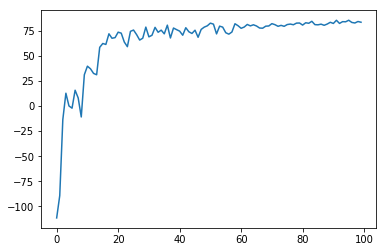

In [85]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)